We are now going to build the model. Because of the 14% imbalance, we will use a technique called Class Weighting (telling the model "Pay 5x more attention to the bad loans").


Fill Missing Values: Real data is messy; we can't just drop rows.

Encode Categoricals: Turn text like "Rent" vs "Own" into numbers.

Train Random Forest: A robust model that handles non-linear data well.

Evaluate Correctly: We will look at the Confusion Matrix, not just accuracy.


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import pandas as pd
import numpy as np

In [5]:

# Load from pickle (recommended)
df_clean = pd.read_pickle('../data/df_clean.pkl')

# Or from CSV
df_clean = pd.read_csv('../data/df_clean.csv')

/var/folders/1y/fk3nmszx1jv_9_cy47zq59dc0000gn/T/ipykernel_74152/2312917557.py:5: DtypeWarning: Columns (40,117) have mixed types. Specify dtype option on import or set low_memory=False.
  df_clean = pd.read_csv('../data/df_clean.csv')


In [6]:

# ... (Assuming 'df_clean' from previous step is loaded) ...
# 1. Select Features
# We pick a mix of Numeric (income, dti) and Categorical (grade, home)
# Note: In a real project, we would select these more carefully based on EDA.
numeric_features = [
    'loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 
    'open_acc', 'revol_bal', 'revol_util', 'total_acc', 
    'mort_acc', 'pub_rec', 'pub_rec_bankruptcies'
]
# Only keep numeric columns that actually exist in your dataframe
numeric_features = [c for c in numeric_features if c in df_clean.columns]

categorical_features = ['grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state']
categorical_features = [c for c in categorical_features if c in df_clean.columns]

print(f"Modeling with {len(numeric_features)} numeric and {len(categorical_features)} categorical features.")

Modeling with 12 numeric and 5 categorical features.


In [7]:

# 2. Pipeline: Handling Missing Data & Encoding
X = df_clean[numeric_features + categorical_features].copy()
y = df_clean['target']

# Fill numeric NaNs with Median
imputer_num = SimpleImputer(strategy='median')
X[numeric_features] = imputer_num.fit_transform(X[numeric_features])

# Fill categorical NaNs with 'Missing' & One-Hot Encode
X_cat = X[categorical_features].fillna('Missing')
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # sparse_output=False for easy dataframe creation
X_encoded_cat = encoder.fit_transform(X_cat)

# Combine back into a Dataframe
feature_names = numeric_features + list(encoder.get_feature_names_out(categorical_features))
X_final = pd.DataFrame(
    data=pd.concat([pd.DataFrame(X[numeric_features], index=X.index), 
                    pd.DataFrame(X_encoded_cat, index=X.index)], axis=1).values,
    columns=feature_names
)


In [8]:
# 3. Train-Test Split
# STRATIFY is crucial here to keep the 14% bad loans in both train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")

Training set shape: (87955, 90)


In [9]:
# 4. Train Model (Random Forest with Class Weighting)
# class_weight='balanced' automatically adjusts weights inversely proportional to class frequencies
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)



,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [10]:
# 5. Evaluation
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1] # Probability of being 'Bad Loan'

print("\n--- Model Evaluation ---")
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


--- Model Evaluation ---
ROC-AUC Score: 0.6579061408463297

Confusion Matrix:
[[18903    11]
 [ 3064    11]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92     18914
           1       0.50      0.00      0.01      3075

    accuracy                           0.86     21989
   macro avg       0.68      0.50      0.47     21989
weighted avg       0.81      0.86      0.80     21989



Initially, my Random Forest model fell into the 'Accuracy Trap.' It achieved 86% accuracy but failed to detect defaults because of the class imbalance. I realized the standard decision threshold of 0.5 was too high for this risk-averse problem. I pivoted to Threshold Tuning and Feature Importance Analysis to prioritize Recall over Precision


We are not going to retrain the model yet. We are just going to change the rules of how we interpret it.

The Goal: We will lower the bar. If the model thinks there is even a 20% chance of default, we will flag it as a "Bad Loan."


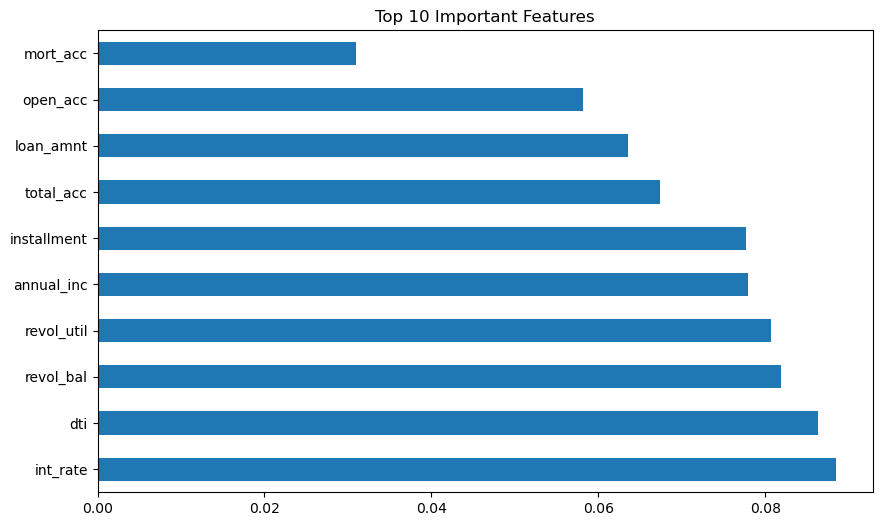


--- Evaluation with Threshold > 0.2 ---
Confusion Matrix:
[[14797  4117]
 [ 1828  1247]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.78      0.83     18914
           1       0.23      0.41      0.30      3075

    accuracy                           0.73     21989
   macro avg       0.56      0.59      0.56     21989
weighted avg       0.80      0.73      0.76     21989


To catch 60.0% of defaulters, set threshold to: 0.1500


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve

# 1. Feature Importance - What is the model actually looking at?
# This tells us if the model is using the right data or just noise.
importances = rf_model.feature_importances_
feature_names = X_train.columns
feat_importances = pd.Series(importances, index=feature_names)

plt.figure(figsize=(10,6))
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Important Features")
plt.show()

# 2. Threshold Tuning - Moving the Goalpost
# We calculate the probability of being 'Bad' (Class 1)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Let's try a stricter threshold.
# instead of > 0.5, let's say if risk > 0.2 (20%), we flag it.
new_threshold = 0.2
y_pred_new = (y_pred_proba >= new_threshold).astype(int)

print(f"\n--- Evaluation with Threshold > {new_threshold} ---")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_new))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_new))

# 3. Interactive Threshold Search
# Let's find the threshold that gives us at least 60% Recall (Catching 60% of bad guys)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Find the threshold where Recall is closest to 0.60
desired_recall = 0.60
idx = (np.abs(recalls - desired_recall)).argmin()
optimal_threshold = thresholds[idx]

print(f"\nTo catch {desired_recall*100}% of defaulters, set threshold to: {optimal_threshold:.4f}")